# A note on preprocessing in Python

Before running a model, such as regression (predicting a continuous variable) or clustering (predicing a discrete variable), on data, you almost always want to do some preprocessing. For numerical variables, it is common to either *normalize* or *standardize* your data. What do these terms mean?

All *normalization* means is scaling a dataset so that its minimum is 0 and its maximum 1. To achieve this we transform each data point $x$ to

$$x_{normalized} = \frac{x-x_{min}}{x_{max}-x_{min}}.$$

*Stardardization* is slightly different; it's job is to centre the data around 0 and to scale with respect to the standard deviation:

$$x_{standardized} = \frac{x-\mu}{\sigma},$$

where $\mu$ and $\sigma$ are the mean and standard deviation of the dataset, respectively. First note that these transformations merely change the range of the data and not the distribution. You may later wish to use any other nunmber of transforms, such as a log transform or a Box-Cox transform, to make your data look more Gaussian (like a bell-curve). But before we go further, it is important to ask the following questions: why do we scale our data? Are there times that it is more appropriate than others? For example, is it more important in classification problems than in regression? Or more important in clustering than in other classification methods?

Let's first delve into classification challenges and see how scaling your data affects clustering methods when compared with regression methods in classification problems:


## Preprocessing for Classification Challenges

In order to see how data scaling affects classification challenges, we'll first synthesize a dataset. This is a good approach so that we know exactly what is going on in it. In the code chunk below, we use scikit-learn's make_blobs function to generate 2000 data points that are in 4 clusters (each data point has 2 predictor variables and 1 target variable):

In [2]:
# Generate some clusteres data (blobs!)
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
n_samples=2000
X, y = make_blobs(n_samples, centers=4, n_features=2,
                  random_state=0)
print('The shape of X is %s' % str(X.shape))
print('The shape of y is %s' % str(y.shape))

The shape of X is (2000, 2)
The shape of y is (2000,)


#### Plotting the synthesized data

We'll now plot in the plane the data that we've synthesized. Each axis is a predictor variable and the colour is a key to the target variable:

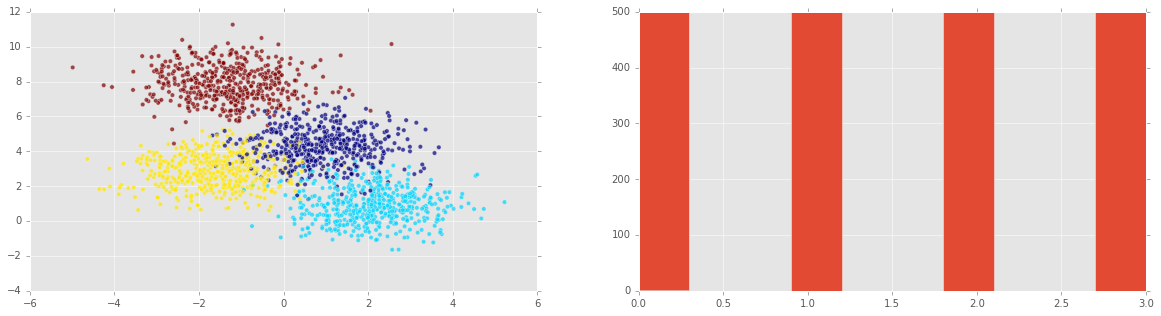

In [3]:
%matplotlib inline
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
plt.style.use('ggplot') # Make the graphs a bit prettier
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.scatter(X[:,0] , X[:,1],  c = y, alpha = 0.7);
plt.subplot(1, 2, 2);
plt.hist(y)
plt.show()
#label axes

*Note: we can see in the 2nd plot that all possible target variables are equally represented. In this case (or even if they are approximately equally represented), we say that the class y is balanced.*

I now want to plot histograms of the features (predictor variables). The easiest way to do this (that I know of) is converting numpy array to a pandas dataframe and calling pd.DataFrame.hist():

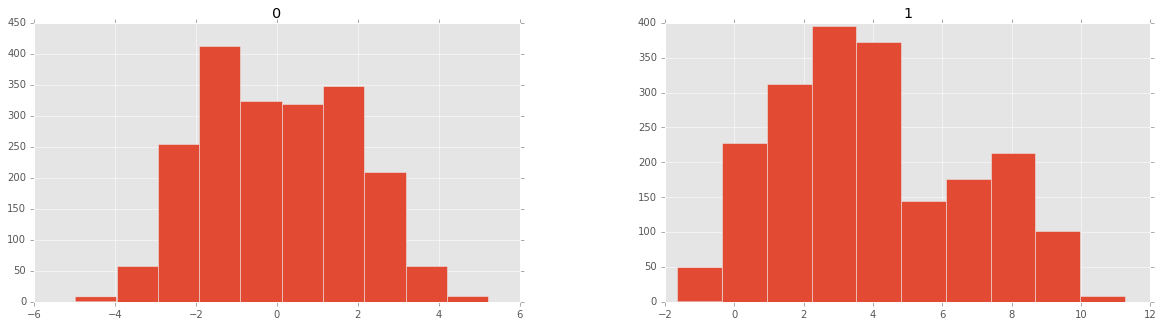

In [43]:
import pandas as pd
df = pd.DataFrame(X)
pd.DataFrame.hist(df, figsize=(20,5));

#### Essential philosophy and practice: preprocessing as an element of the pipeline

Preprocessing does not occur in a vacuum. This to say that we don't preprocess for preprocessing's sake, but we do it in order to improve how well our models work, that is, their predictive power. Here we will delve into how scaling our data affects (i) clustering algorithms for classification (in the form of k-nearest neighbours) & (ii) regression algorithms for classification (in the form of logistic regression).

We can reformulate this question as follows: does k-nearest neighbours perform better as a classifier when we scale the data, or when we don't, and similarly for logistic regression?

To answer the reformulated question, we realise that we need to know a bit more about these models and how we can gauge how good they are. That is, we need to define performance measures for the models. Let's do that now:

#### K-nearest neighbours: how it works

[Insert here description of K nearest neighbours]

#### K-nearest neighbours: how well does it perform?

There are a number of performance measures for classification challenges. It is of the utmost importance to realise that the choice of performance measure is deeply domain & question specific [give some examples here]. In the case of a dataset with balanced classes, data scientists commonly look at *accuracy* as a performance measure. In fact, as we'll see, accuracy is the default scoring method for both K-nearest neighbours and logistic regression in scikit-learn. So what is accuracy? It is merely the number of correct predictions divided by the total number of data points:

$$\text{Accuracy}=\frac{\text{Number of Correct Predictions}}{\text{Total Number of Data Points}}.$$

*Note: accuracy can also be defined in terms of a confusion matrix; commonly defined for binary classification in terms of true positives & false negatives; give example of class imbalance in which accuracy is a poor measure (& what about Cohen's Kappa, then?)*

#### K-nearest neighbours: performance in practice

It is all well and good to have a measure of performance such as accuracy (or whatever), but if we fit the model on all of the data we have, what dataset are we going we going to report the accuracy from. Remember that we want a model that generalises well to new data. Thus, if we train our model on a dataset D, reporting the accuracy of the model on D may make it look as though it performs better than it actually does. This is precisely the concept of **overfitting** (see Appendix). To combat this issue, data scientists will commonly train their model on a subset of the data, called the **training set** and evaulate it's performance on the rest of the data, the **test set**. This is precisely what we're going to do here! A general rule of thumb is to use approximately 80% of the data for training & 20% for test. Let's now split our data and plot both training and test sets to make sure that they're both representative of the dataset as a whole:

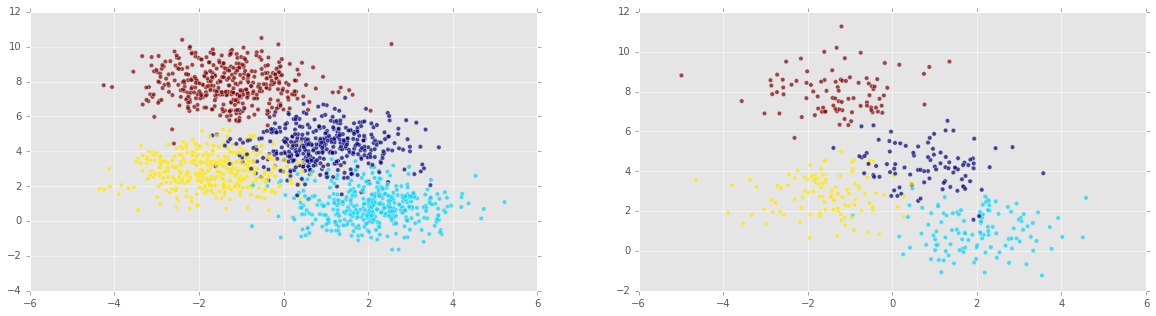

In [28]:
s = int(.8*n_samples)
X_train = X[:s]
y_train = y[:s]
X_test = X[s:]
y_test = y[s:]
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.scatter(X_train[:,0] , X_train[:,1],  c = y_train, alpha = 0.7);
plt.subplot(1, 2, 2);
plt.scatter(X_test[:,0] , X_test[:,1],  c = y_test, alpha = 0.7);
plt.show()

Looking good! Now let's instantiate a k-nearest neighbors voting classifier and train it on our training set:

In [29]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)

Now that we have trained our model we can fit it to our test set and compute the accuracy:

In [8]:
print('KNN score for test set: %f' % knn_model.score(X_test, y_test))

KNN score for test set: 0.930000


We can also re-fit it to our training set and compute the accuracy. We would expect it to perform better on the training set than the test set:

In [10]:
print('KNN score for training set: %f' % knn_model.score(X_train, y_train))

KNN score for training set: 0.943750


#### Now with scaling

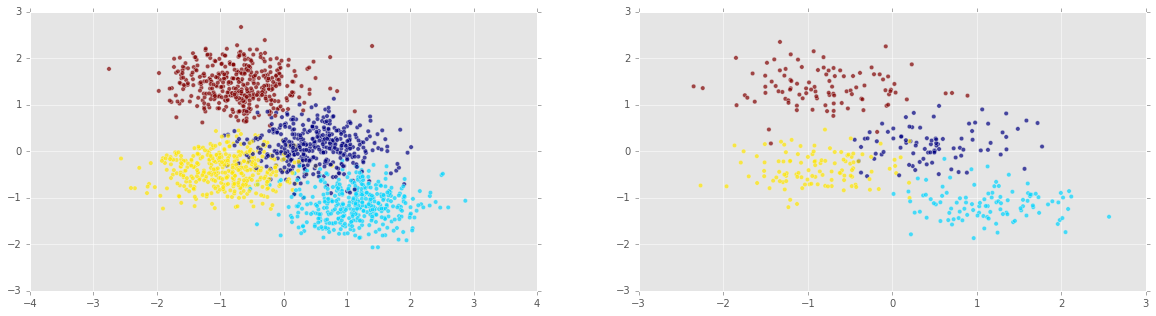

In [34]:
from sklearn.preprocessing import scale
# from sklearn.preprocessing import StandardScaler
Xs = scale(X)
s = int(.2*n_samples)
Xs_train = Xs[s:]
y_train = y[s:]
Xs_test = Xs[:s]
y_test = y[:s]
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.scatter(Xs_train[:,0] , Xs_train[:,1],  c = y_train, alpha = 0.7);
plt.subplot(1, 2, 2);
plt.scatter(Xs_test[:,0] , Xs_test[:,1],  c = y_test, alpha = 0.7);
plt.show()

In [35]:
knn_model_s = knn.fit(Xs_train, y_train)
print('KNN score for test set: %f' % knn_model_s.score(Xs_test, y_test))

KNN score for test set: 0.930000


It doesn't perform any better. Probably because both features were already around the same range. It really makes sense to scale when variables have widely varying ranges. To see this in action, we're going to add another feature. Moreover, this feature will bear no relevance to the target variable: it will be mere noise.

In [53]:
# Add noise column to predictor variables
ns = 100 # Strength of noise term
newcol = np.transpose([ns*np.random.rand(n_samples)])
Xn = np.concatenate((X, newcol), axis = 1)
np.shape(Xn)

(2000, 3)

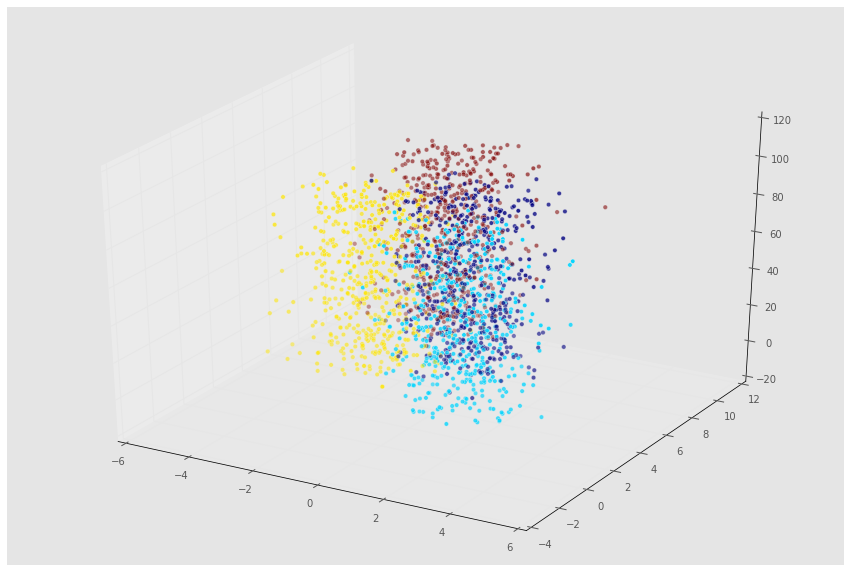

In [54]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10));
ax = fig.add_subplot(111, projection='3d');
ax.scatter(Xn[:,0], Xn[:,1], Xn[:,2], c = y);
# ax.set_xlabel('1st PC')
# ax.set_ylabel('2nd PC')
# ax.set_zlabel('3rd PC')

In [55]:
s = int(.9*n_samples)
X_train = Xn[:s]
y_train = y[:s]
X_test = Xn[s:]
y_test = y[s:]

knn = neighbors.KNeighborsClassifier()
logistic = linear_model.LogisticRegression()

print('KNN score: %f' % knn.fit(X_train, y_train).score(X_test, y_test))
print('LogisticRegression score: %f'
      % logistic.fit(X_train, y_train).score(X_test, y_test))

KNN score: 0.905000
LogisticRegression score: 0.935000
